In [299]:
import numpy as np
import scipy
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import torch
from torch import nn
import math
relu = torch.nn.ReLU()

In [300]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.figsize': (8, 6),
    'font.size': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'axes.linewidth': 3,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'lines.linewidth': 3,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.minor.visible': False,
    'ytick.minor.visible': False,
    'legend.fontsize': 14,
    'legend.frameon': False,
    'legend.loc': 'upper right',
})

# Double-ring model of head direction circuit

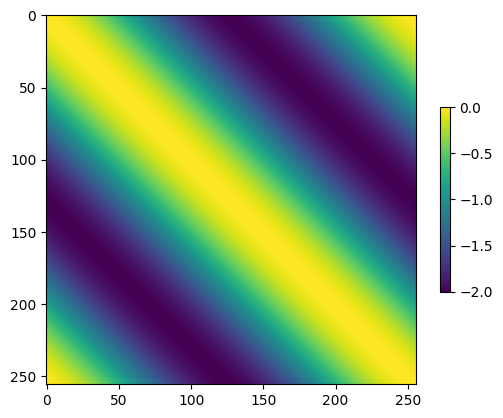

In [ ]:
N = 256
theta = 2 * np.pi * np.arange(N) / N
Delta = 2 * np.pi * (2 / N)

# Reshape theta into two separated 2D arrays (matrix)
theta_i = np.reshape(theta, (N, 1))
theta_j = np.reshape(theta, (1, N))

# Compute W
W_L = np.cos(theta_i - theta_j - Delta) - 1
W_R = np.cos(theta_i - theta_j + Delta) - 1

plt.imshow(W_L)
plt.colorbar(shrink=0.5)
plt.show()

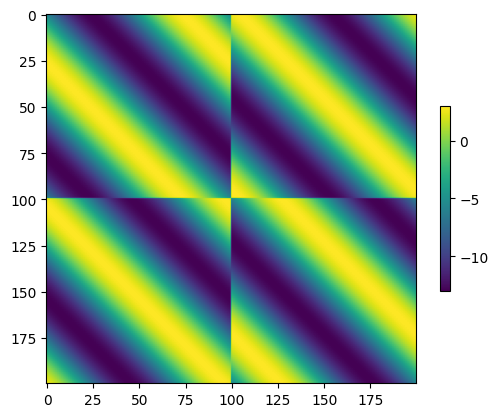

In [ ]:
import torch

def generate_W(N=100, J_0=-5, K_0=-5, J_1=8, K_1=8, phi_degree=80, psi_degree=50, device='cpu'):
    theta = 2 * np.pi * torch.arange(N).float() / N
    # phi = torch.tensor(phi_degree).float() * (180 / torch.pi)
    # psi = torch.tensor(psi_degree).float() * (180 / torch.pi)

    def w(theta, P_0, P_1):
        return P_0 + P_1 * torch.cos(theta)

    W_same_L = torch.stack([w(theta - theta[j] - phi_degree, J_0, J_1) for j in range(len(theta))])
    W_diff_L = torch.stack([w(theta - theta[j] + psi_degree, K_0, K_1) for j in range(len(theta))])
    W_same_R = torch.stack([w(theta - theta[j] + phi_degree, J_0, J_1) for j in range(len(theta))])
    W_diff_R = torch.stack([w(theta - theta[j] - psi_degree, K_0, K_1) for j in range(len(theta))])

    W_full = torch.cat([
            torch.cat([W_same_L, W_diff_L],dim=1),
            torch.cat([W_diff_R, W_same_R],dim=1)
        ],dim=0)

    # Send tensor to specified device
    W_full_tensor = W_full.to(device)

    return W_full_tensor.double()

plt.imshow(generate_W())
plt.colorbar(shrink=0.5)
plt.show()

In [ ]:
N = 100
periodic = False

m = 4              # CV = 1/sqrt(m)
x_prefs = np.linspace(1,N,N)/N # inherited location preferences (m)

# FF input
beta_vel = 1.5    # velocity gain
beta_0 = 70        # uniform input
alpha = 1000       # weight imbalance parameter
gamma = 1.05/100   # Center Surround weight params
beta = 1/100       # Center Surround weight params

# Temporal parameters
T = 100            # length of integration time blocks (s)
dt = 1/2000        # step size of numerical integration (s)
tau_s = 30/1000    # synaptic time constant (s)

# Graphing parameters
bins = np.linspace(0+.01,1-.01,50)
T_steps = int(T/dt)

# Trajectory Data (Sinusoidal)
x = (np.sin(np.arange(dt,T+dt,dt)*2*np.pi/10)+1)/2
v= np.zeros(int(T/dt))
v[1:] = np.diff(x)/dt

z = np.arange(-N/2,N/2)

# Feed forward network input
if periodic == 1:
    # gaussian FF input for aperiodic network
    envelope = np.exp(-4*(z/(N/2))**2)
else:
    envelope = np.ones(N)

s_prev = np.zeros(2*N) #Population activity
spk = np.zeros((2*N,T_steps))  # Total spiking
spk_count = np.zeros(2*N) # Current spiking

# Weight setup
crossSection = alpha*(np.exp(-gamma*z**2)-np.exp(-beta*z**2))
crossSection = np.roll(crossSection, int(N/2-1))

W_RR = np.zeros((N,N))
W_LL = np.zeros((N,N))
W_RL = np.zeros((N,N))
W_LR = np.zeros((N,N))

for i in range(N):
    W_RR[i,:] =  np.roll(crossSection,i - 1) # Right neurons to Right neurons
    W_LL[i,:] =  np.roll(crossSection,i + 1) # Left neurons to Left neurons
    W_RL[i,:] =  np.roll(crossSection,i)     # Left neurons to Right neurons
    W_LR[i,:] =  np.roll(crossSection,i)     # Right neurons to Left neurons

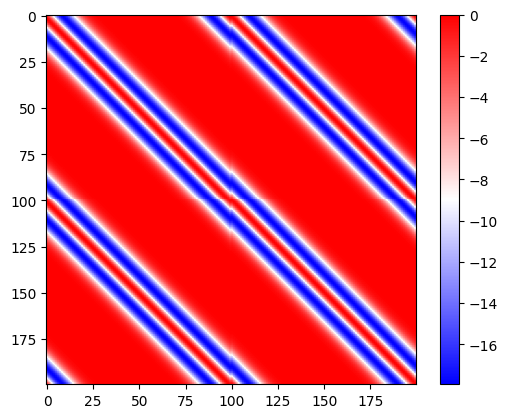

In [ ]:
W = np.block([
    [W_RR, W_RL],
    [W_LR, W_LL]
])

plt.imshow(W, cmap='bwr')
plt.colorbar()
plt.show()

# Head direction integration task

In [301]:
def OU(alpha=0, mu=0, sigma=1, dt=0.1, num_timesteps=100, bound=0.5):
    """Implements a modified Ornstein-Uhlenbeck process to generate bounded noise.

    Args:
    alpha (float): rate of mean reversion
    mu (float): long-term mean
    sigma (float): standard deviation of noise
    dt (float): time step
    num_timesteps (int): number of time steps
    bound (float): maximum absolute value of the noise

    Returns:
    numpy array: modified OU process noise
    """

    x = np.zeros(num_timesteps)
    # x[0] = mu + sigma * np.sqrt(dt) * np.random.normal(0, 1)
    x[0] = 0

    for t in range(1, num_timesteps):
        dx = alpha * (mu - x[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
        # dx = x[t-1] * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
        x[t] = np.clip(x[t-1] + dx, -bound, bound)

    return x

import numpy as np

def zero_inflated_OU(alpha=0, mu=0, sigma=1, dt=0.1, num_timesteps=100, bound=0.5, p_zero=0.1):
    """Implements a zero-inflated Ornstein-Uhlenbeck process to generate bounded noise.

    Args:
    alpha (float): rate of mean reversion
    mu (float): long-term mean
    sigma (float): standard deviation of noise
    dt (float): time step
    num_timesteps (int): number of time steps
    bound (float): maximum absolute value of the noise
    p_zero (float): probability of the process being at zero

    Returns:
    numpy array: modified OU process noise
    """

    x = np.zeros(num_timesteps)
    x[0] = 0

    for t in range(1, num_timesteps):
        if np.random.uniform(0, 1) < p_zero:
            dx = 0  # Process stays at zero with probability p_zero
        else:
            dx = alpha * (mu - x[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
        x[t] = x[t-1] + dx
        x[t] = np.clip(x[t], -bound, bound)

    return x


def generate_dataset(num_samples, num_timesteps, seed=42, constant_omega=False, alpha=0, mu=0, sigma=1e-4, p_zero=.5, dt=0.1, bound=np.inf, omega_range=None):
    # Initialize arrays to store inputs and targets
    inputs = np.zeros((num_samples, num_timesteps, 3))
    targets = np.zeros((num_samples, num_timesteps, 2))

    np.random.seed(seed)

    # Generate dataset
    for i in range(num_samples):
        if constant_omega:
            if omega_range is not None and i <= len(omega_range):
                omegas = num_timesteps * [omega_range[i]]
            else:
                omega = constant_omega

        else:
            # omegas = OU(alpha=alpha, mu=mu, sigma=sigma, dt=dt, num_timesteps=num_timesteps, bound=bound)
            omegas = zero_inflated_OU(alpha=alpha, mu=mu, sigma=sigma, dt=dt, num_timesteps=num_timesteps, p_zero=p_zero, bound=bound)
            omega = omegas[0]  # Use the first omega value from the sequence

        # Sample initial angle between 0 and 2*pi
        # theta0 = np.random.uniform(0, 2*np.pi)
        theta0 = 0
        theta = theta0

        # Compute cos and sin of initial angle
        x0 = np.cos(theta0)
        y0 = np.sin(theta0)

        for j in range(num_timesteps):
            omega = omegas[j]

            # Use fourth-order Runge-Kutta method to compute change in angle
            k1 = omega * dt
            k2 = (omega + 0.5 * k1) * dt
            k3 = (omega + 0.5 * k2) * dt
            k4 = (omega + k3) * dt
            dtheta = (k1 + 2 * k2 + 2 * k3 + k4) / 6
            theta = (theta + dtheta) % (2 * np.pi)

            # Store input
            inputs[i, j, 0] = omega
            inputs[i, j, 1] = x0
            inputs[i, j, 2] = y0

            # Store target
            targets[i, j, 0] = np.cos(theta)  # x
            targets[i, j, 1] = np.sin(theta)  # y

    return inputs, targets


<ipython-input-302-0b7d91486c98>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


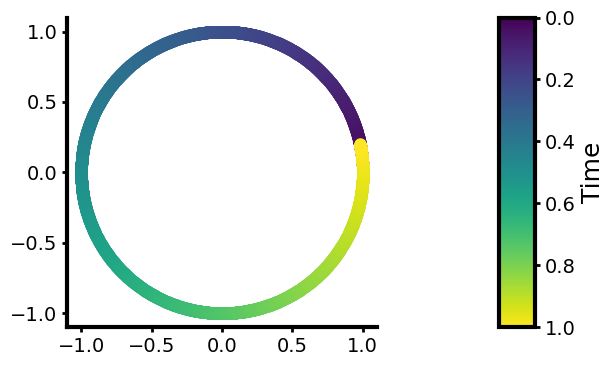

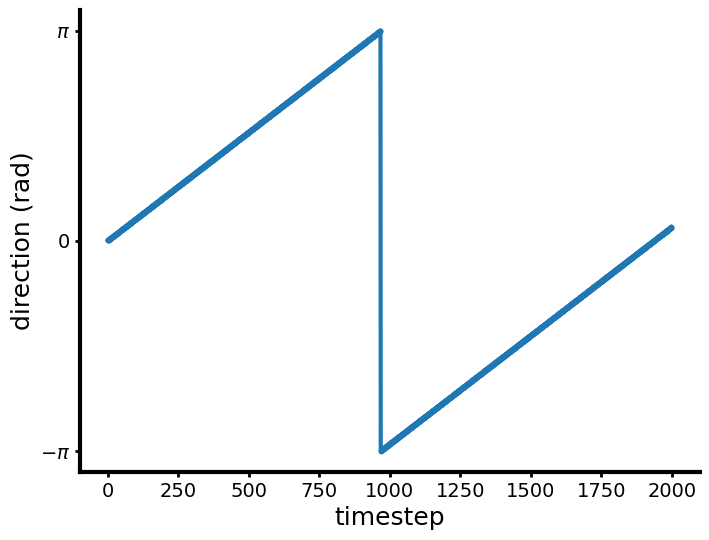

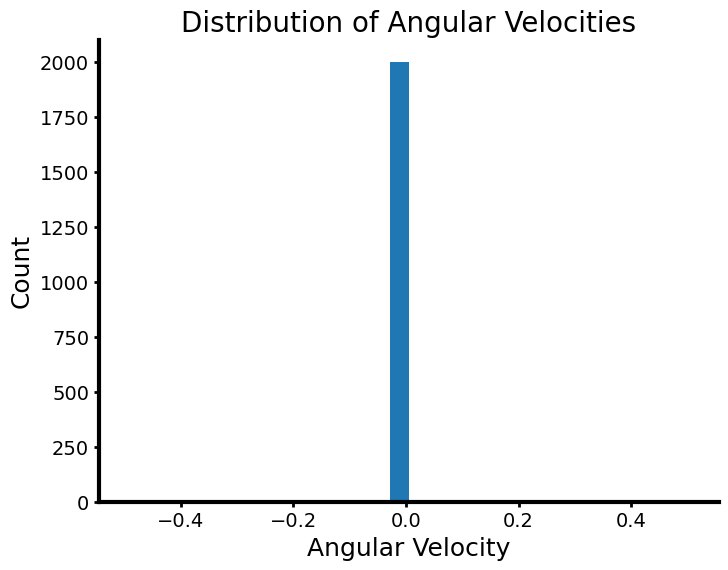

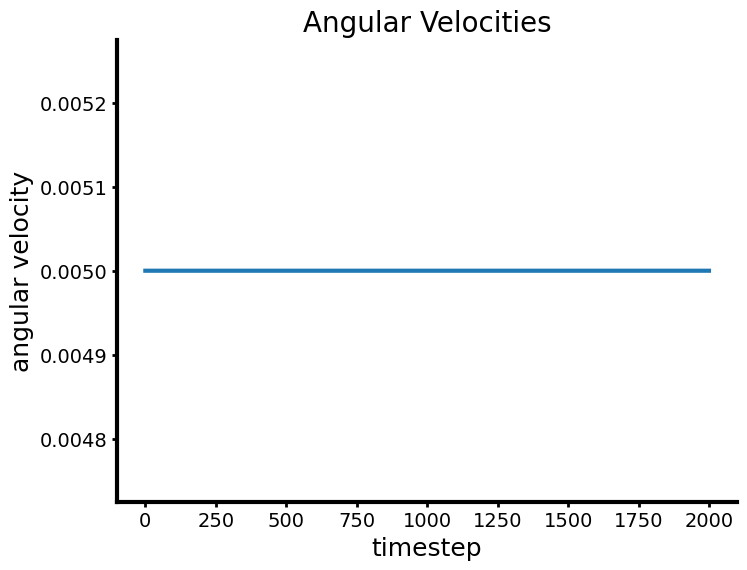

In [302]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# Generate dataset
# omega_range = np.linspace(-0.2, 0.2, 20)
# omega_range = np.insert(omega_range, 0, 0) # include 0
omega_range = [0.005]
num_samples = len(omega_range)
num_timesteps = 2000
num_samples = 1

# inputs, targets = generate_dataset(num_samples, num_timesteps, seed=42, constant_omega=False, alpha=1.05, mu=0.05, sigma=0.1, p_zero=.95, dt=.1)
# inputs, targets = generate_dataset(num_samples, num_timesteps, constant_omega=0.1, alpha=0.05, mu=0, sigma=.1, dt=.1, bound=1)
inputs, targets = generate_dataset(num_samples, num_timesteps, constant_omega=True, omega_range=omega_range, dt=.5, sigma=0.01, alpha=0.05)



# Plot targets on a 2D unit circle with time-based color gradient and colormap
fig, axs = plt.subplots(1, 2, figsize=(8,4), gridspec_kw={'width_ratios': [1, 0.05]})

circle = plt.Circle((0,0), radius=1, fill=False)
axs[0].add_patch(circle)
axs[0].set_xlim([-1.1, 1.1])
axs[0].set_ylim([-1.1, 1.1])
axs[0].set_aspect('equal')

cmap = cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, num_timesteps))

sample_idx = 0 # sample to plot

for i in range(num_timesteps):
    axs[0].plot(targets[sample_idx, i, 0], targets[sample_idx, i, 1], marker='o', markersize=8, color=colors[i])

sc = axs[1].scatter([],[], c=[], cmap='viridis')
clb = plt.colorbar(sc, cax=axs[1])
clb.ax.invert_yaxis()
clb.set_label('Time')

plt.tight_layout()
plt.show()

plt.plot(range(num_timesteps), np.arctan2(targets[sample_idx, :, 1], targets[sample_idx, :, 0]), marker='o', markersize=3)
plt.xlabel('timestep')
plt.ylabel('direction (rad)')
plt.yticks(np.linspace(-np.pi, np.pi, 3), [r'$-\pi$', r'$0$', r'$\pi$'])
plt.show()


velocities = inputs[sample_idx, :, 0].reshape(-1,1)
# Plot histogram of velocities
plt.hist(velocities, bins=30)
plt.title("Distribution of Angular Velocities")
plt.xlabel("Angular Velocity")
plt.ylabel("Count")
plt.show()

plt.plot(velocities)
plt.title("Angular Velocities")
plt.xlabel("timestep")
plt.ylabel("angular velocity")
plt.show()

In [ ]:
inputs.shape

(1, 2000, 3)

In [ ]:
targets.shape

(1, 2000, 2)

# Ring integrator module

In [303]:
def generate_w_matrix(device, nNeurons, nBumps,length=40, wWeight=8.0, wShift=2, wScaling=True):
    """
    Generating synaptic connectivity matrix

    Inputs
    ------
    wWeight : positive value; sets the strength of the most inhibitory connection
    wShift : synaptic output shift for L and R populations (xi)
    wScaling : scale the raw wWeight by nNeurons and nBumps
    """
    # Calculating synaptic connectivity values #TODO change for diff connect, too small will result in multiple bumps
    # length = nNeurons / (
    #     2.28 * nBumps
    # )  # inhibition length l that produces nBumps (Eq. 47)
    length2 = int(2 * np.ceil(length))
    positions = np.arange(-length2, length2 + 1)  # Only short-range synapses between -2l and 2l
    if wScaling:  # Scale wWeight so bump shape remains the same
        strength = wWeight * nBumps / nNeurons
    else:
        strength = wWeight

    # Cosine-based connectivity function (Eq. 38)
    values = strength * (np.cos((np.pi * positions / length)) - 1) / 2
    values *= np.abs(positions) < 2 * length

    # Adding values to form unshifted row of w matrix. We form the row this way so that
    # synaptic weights are wrapped around the network in case 4 * length > nNeurons
    # (Eq. 127)
    wUnshifted = torch.zeros(nNeurons, device=device)
    for position, w in zip(positions, values):
        wUnshifted[position % nNeurons] += w

    # Form unshifted matrix of dim (nNeurons, nNeurons), then shift and form final matrix
    # of dim (2 * nNeurons, 2 * nNeurons)
    wQuadrant = torch.vstack([wUnshifted.roll(i) for i in range(nNeurons)])
    wMatrix = torch.hstack((wQuadrant.roll(-wShift, 0), wQuadrant.roll(wShift, 0)))
    wMatrix = torch.vstack((wMatrix, wMatrix))

    return wMatrix

def generate_alpha_matrix(neurons,length,alpha,wWeight=8,
                wShift=2,wScaling=True,device='cpu'):
    cutoff = int((1-alpha)*length)
    wMatrix = generate_w_matrix(device,neurons+cutoff,1,length,wWeight,wShift,wScaling)
    real_w = torch.zeros((neurons*2,neurons*2),device=device)
    end = 2*neurons + cutoff
    real_w[:neurons,:neurons] = wMatrix[:neurons,:neurons] #top left
    real_w[neurons:,neurons:] = wMatrix[neurons+cutoff:end,neurons+cutoff:end] #bottom right
    real_w[:neurons,neurons:] = wMatrix[:neurons,neurons+cutoff:end] #off diagonals
    real_w[neurons:,:neurons] = wMatrix[neurons+cutoff:end,:neurons]
    return real_w

In [304]:
torch.set_default_tensor_type(torch.DoubleTensor)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [305]:
class RingModule(nn.Module):
    def __init__(self,
                 input_size,
                 device='cpu',
                 nNeurons=100,
                 nBumps=1,
                 length=40,
                 gNoiseMag=None,
                 fano=None,
                 dt=0.5,
                 tau=10.0,
                 alpha = 1.0,
                 wWeight=8.0,
                 wShift=2,
                 wScaling=True,
                 restingMag=1.0,
                 gammaMultiplier=1.0,
                 pulseMag = 1.0,
                 pulsePosition = 12
                 ):

        super().__init__()

        self.device = device
        self.input_size = input_size
        self.nNeurons = nNeurons
        self.hidden_size = 2 * self.nNeurons
        self.nBumps = nBumps
        self.dt = dt
        self.length = length
        self.tau = tau
        self.alpha = dt / tau
        self.phiFunction = nn.ReLU()
        self.wAttractor = generate_alpha_matrix(nNeurons,
                                                length,
                                                alpha,
                                                wWeight,
                                                wShift,
                                                wScaling,
                                                device=device).to(device)

        self.gNoiseMag = gNoiseMag
        self.fano = fano
        self.restingMag = restingMag
        self.gammaMultiplier = gammaMultiplier

        self.pulseMag = pulseMag
        self.pulsePosition = pulsePosition

        # Setup inputs to ring
        self.input_to_vel = nn.Linear(input_size, 1, bias=False).to(device) # learnable
        # nn.init.ones_(self.input_to_vel.weight)
        self.vel_to_ring = nn.Linear(1, self.hidden_size, bias=True).to(device) # unlearnable
        self.vel_to_ring.weight.requires_grad = False
        self.vel_to_ring.bias.requires_grad = False # fix the bias during training
        self.gamma = (  # Coupling strength between 'velocity' neuron and network
            gammaMultiplier * torch.cat((-torch.ones(self.nNeurons), torch.ones(self.nNeurons))).to(device)
        ).unsqueeze(1)
        self.vel_to_ring.weight.data.copy_(self.gamma); # set coupling from 'velocity' neuron to ring network manually
        self.vel_to_ring.bias.copy_(torch.ones((self.hidden_size,))); # bias is fixed at 1

    def init_hidden(self):
        """
        Initialize the activities in each ring.

        - pulsePosition is chosen to inject a delta pulse of activity at the specified neuron index in each ring.
        - Dynamics are run until bumps stabilize at these positions on each ring.
        - The resulting activities form rings' activity at initialization.
        """

        bump_period = int(self.nNeurons / self.nBumps) # bump distance
        pulse_inds = bump_period * np.arange(self.nBumps)
        pulse_inds = np.concatenate((pulse_inds, self.nNeurons + pulse_inds))

        # pulsePosition = 12 # !important! for now, bumps will always be initialized at the 12th neuron in each ring

        pulse_inds += int(self.pulsePosition % bump_period)
        pulse_inputs = torch.zeros(2 * self.nNeurons, device=self.device)
        pulse_inputs[pulse_inds] = self.pulseMag

        hidden = 0.05 * torch.rand(2 * self.nNeurons, device=self.device)

        tSetup = 500

        init_drive = torch.tensor([.1,1,0]).double().to(self.device) # some arbitrary drive to initialize
        for t in np.arange(0, tSetup): # run dynamics a little
            hidden = self.recurrence(init_drive, hidden)

        while torch.argmax(hidden[:self.nNeurons]) != self.pulsePosition: # keep running dynamics until bump aligns with initial pulse location
            hidden = self.recurrence(init_drive, hidden)

        # print('bumps initialized')

        return hidden


    def recurrence(self, input, hidden):
        # h2h = torch.matmul(self.wAttractor, hidden.T)
        h2h = hidden @ self.wAttractor
        i2h = self.vel_to_ring(self.input_to_vel(input))
        h_pre_act = i2h + h2h

        h_new = (1 - self.alpha)*hidden + self.alpha*relu(h_pre_act)
        return h_new

    def forward(self, input, hidden=None):
        if hidden is None: # initialize ring neuron states
            hidden = self.init_hidden()

        # propagate input through ring module
        recurrent_acts = []
        steps = range(input.shape[0])
        for t in steps:
            hidden = self.recurrence(input[t, ...], hidden)

            # store ring network activity
            recurrent_acts.append(hidden)

        hidden_acts = torch.stack(recurrent_acts, dim=0)

        return hidden_acts,  hidden


class ModRNN(torch.nn.Module):
    def __init__(self, input_size, output_size, **kwargs):
        super().__init__()

        # continuous-time RNN with fixed ring module
        self.CTRNN = RingModule(input_size, **kwargs)

        # output from recurrent layer
        self.output = torch.nn.Linear(self.CTRNN.hidden_size, output_size, bias=True).to(device)
        # torch.nn.init.kaiming_uniform_(self.output.weight)

    def forward(self, x):
        activity, hidden_state = self.CTRNN(x)
        out = self.output(activity)

        return out, activity

## Testing bump initialization

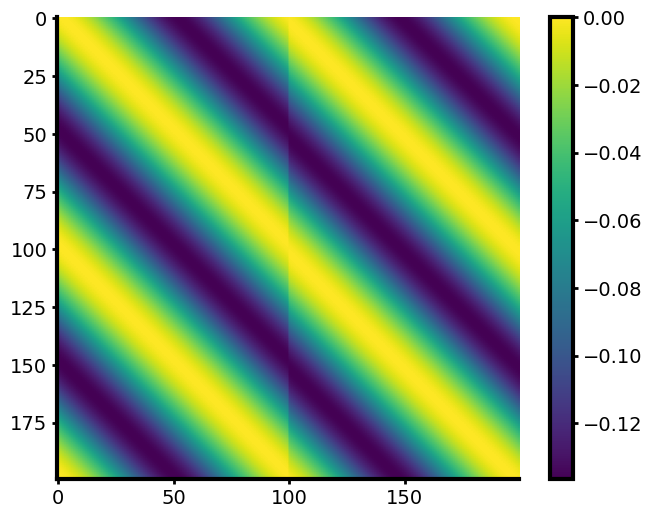

KeyboardInterrupt: ignored

In [306]:
nNeurons = 100 # nNeurons in each of 2 rings
nBumps = 1

W = generate_w_matrix(device, nNeurons=nNeurons, nBumps=nBumps, length=40, wWeight=8.0, wShift=2, wScaling=True)
plt.imshow(W.detach().cpu().numpy())
plt.colorbar()
plt.show()

pulseMag = 1.0

bump_period = int(nNeurons / nBumps) # bump distance
pulse_inds = bump_period * np.arange(nBumps) # initialize bump(s)
pulse_inds = np.concatenate((pulse_inds, nNeurons + pulse_inds)) # both populations

pulsePosition = 12 # always apply pulse at this neuron
pulse_inds += int(pulsePosition % bump_period)

# print(pulse_inds)

pulse_inputs = torch.zeros(2 * nNeurons, device=device)
pulse_inputs[pulse_inds] = pulseMag

hidden =  0.05 * torch.rand(2 * nNeurons, device=device) + pulse_inputs

plt.plot(hidden.detach().cpu().numpy())
plt.show()

# init_hidden = torch.zeros_like(init_input)

In [ ]:
def evolve_network(input, hidden):

        restingInput = 1 * torch.ones(2 * nNeurons, device=device)
        gamma = (  # Coupling strength between input drive and network
            1
            * 1
            * torch.cat((-torch.ones(nNeurons), torch.ones(nNeurons))).to(device)
        )
        dt = .5
        tau = 1.0
        alpha = dt / tau

        # delta_h = -hidden + restingInput * (1.0 + gamma * input)
        # delta_h += torch.matmul(W, relu(hidden))

        h2h = W @ hidden
        i2h = restingInput * (1 + gamma * input)
        # i2h = gamma * input


        h_pre_act = i2h + h2h
        h_new = (1 - alpha)*hidden + alpha*relu(h_pre_act)

        # h_new = hidden + (dt / tau) * delta_h
        return h_new

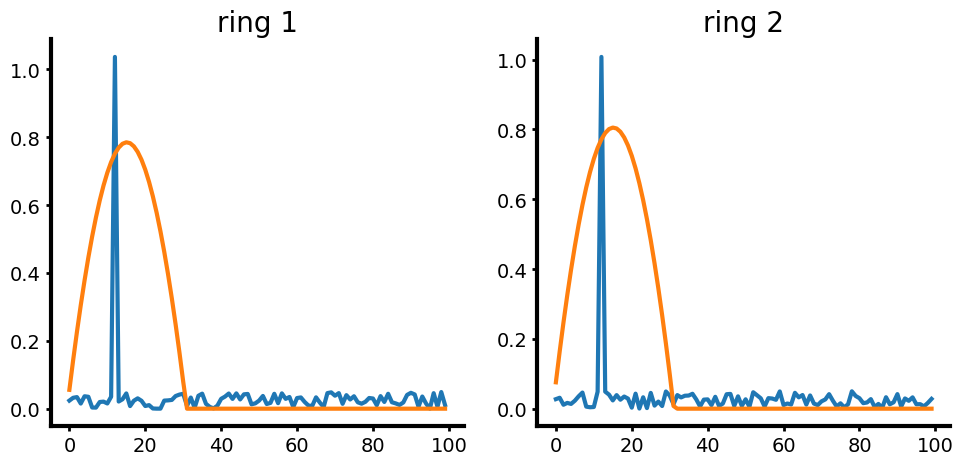

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) # create a figure with two subplots

# pulses before initialization
axs[0].plot(hidden[:nNeurons].detach().cpu().numpy())
axs[1].plot(hidden[nNeurons:].detach().cpu().numpy())

drive = 0.01

tSetup = 100
for t in np.arange(0, tSetup):
    hidden = evolve_network(drive, hidden)

# while torch.argmax(hidden[:nNeurons]) != pulsePosition:
#     hidden = evolve_network(drive, hidden)


# we've let the dynamics run until the bumps settle to the position of the initial pulses in each ring
axs[0].plot(hidden[:nNeurons].detach().cpu().numpy())
axs[1].plot(hidden[nNeurons:].detach().cpu().numpy())

axs[0].set_title('ring 1')
axs[1].set_title('ring 2')
# Show both plots
plt.tight_layout()
plt.show()

Experimenting with ways of setting up the input projections to double ring network:

In [ ]:
input_to_vel = nn.Linear(3, 1, bias=False)
vel_to_ring = nn.Linear(1, 2 * nNeurons, bias=True)
vel_to_ring.bias.data.copy_(torch.ones((2 * nNeurons,)));

In [ ]:
gamma = (1* torch.cat((-torch.ones(nNeurons), torch.ones(nNeurons)))).unsqueeze(1).to(device)

# Set the layer's weight
vel_to_ring.weight.data.copy_(gamma);

In [ ]:
input = torch.tensor([.1,1,0])

In [ ]:
input_to_vel(input)

tensor([0.0233], grad_fn=<SqueezeBackward4>)

In [ ]:
vel_to_ring(input_to_vel(input))[:nNeurons]

tensor([0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767,
        0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767,
        0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767,
        0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767,
        0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767,
        0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767,
        0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767,
        0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767,
        0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767,
        0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767,
        0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767, 0.9767,
        0.9767], grad_fn=<SliceBackward0>)

In [ ]:
vel_to_ring(input_to_vel(input))[nNeurons:]

tensor([1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233,
        1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233,
        1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233,
        1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233,
        1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233,
        1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233,
        1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233,
        1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233,
        1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233,
        1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233,
        1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233, 1.0233,
        1.0233], grad_fn=<SliceBackward0>)

In [ ]:
vel_to_ring(input_to_vel(input))

tensor([1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079,
        1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079,
        1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079,
        1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079,
        1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079,
        1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079,
        1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079,
        1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079,
        1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079,
        1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079,
        1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079, 1.0079,
        1.0079, 0.9921, 0.9921, 0.9921, 0.9921, 0.9921, 0.9921, 0.9921, 0.9921,
        0.9921, 0.9921, 0.9921, 0.9921, 

## Training

In [343]:
import torch.nn.functional as F
torch.set_default_dtype(torch.double)

torch.set_default_tensor_type(torch.DoubleTensor)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device = {device}')

input_size = 3
output_size = 2

net = ModRNN(input_size,
             output_size,
             device=device,
             nNeurons=100,
             nBumps=1,
             length=30,
             gNoiseMag=None,
             fano=None,
             dt=.5,
             tau=10.0,
             alpha = 1.0,
             wWeight=10.0,
             wShift=2,
             wScaling=True,
             restingMag=1.0,
             gammaMultiplier=1,
             pulseMag = 1.0,
             pulsePosition = 12
            )

device = cpu


Check initialization:

In [331]:
h = net.CTRNN.init_hidden()

In [313]:
h.shape

torch.Size([200])

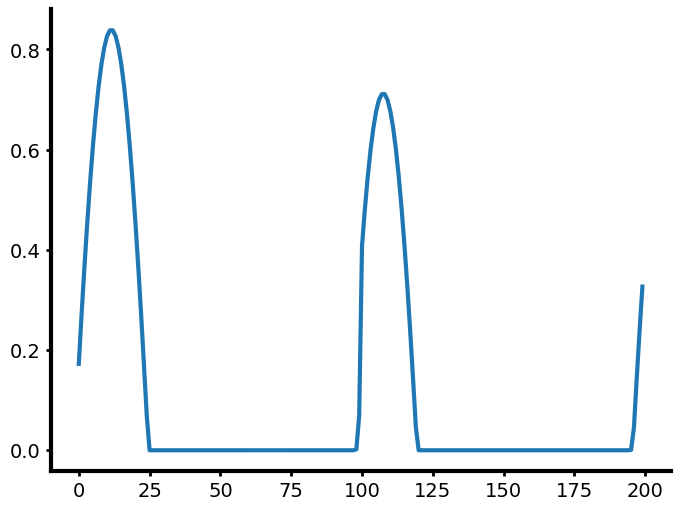

In [332]:
plt.plot(h.detach().cpu().numpy())
plt.show()

Initialization working. Now generate some training data; we'll start with a single sample just to see if things work properly.

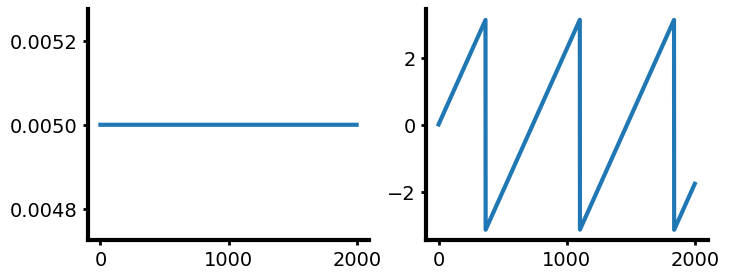

In [387]:
inputs, targets = generate_dataset(num_samples, num_timesteps, constant_omega=True, omega_range=omega_range, dt=1)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(inputs[0, :, 0])
ax[1].plot(np.arctan2(targets[0, :, 1], targets[0, :, 0]))
plt.show()

In [388]:
torch.set_default_tensor_type(torch.DoubleTensor)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device = {device}')

input_size = 3
output_size = 2

net = ModRNN(input_size,
             output_size,
             device=device,
             nNeurons=100,
             nBumps=1,
             length=30,
             gNoiseMag=None,
             fano=None,
             dt=.5,
             tau=10.0,
             alpha = 1.0,
             wWeight=11.0,
            #  wWeight=8.0,
             wShift=2,
             wScaling=True,
             restingMag=1.0,
             gammaMultiplier=1,
             pulseMag = 1.0,
             pulsePosition = 12
            )

criterion = torch.nn.MSELoss()
learning_rate = 5e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
num_epochs = 10_000
# clip_value = 2 # Define the gradient clip value

losses = []
perfs = []
nNeurons=100
# hidden_activity = torch.zeros((100, inputs.shape[1], 2*nNeurons))
# vel_neuron_activity = torch.zeros((100, inputs.shape[1], 1))

for epoch in range(num_epochs):

    running_loss = 0.0
    indices = torch.randperm(num_samples)

    # print(net.CTRNN.input_to_vel.weight.data.detach().cpu().numpy())
    for i in range(num_samples):

        idx = indices[i]
        x = torch.Tensor(inputs[idx]).unsqueeze(1).to(device)
        y = torch.Tensor(targets[idx]).unsqueeze(1).to(device)

        outputs, activity = net(x)
        # outputs = torch.Tensor(outputs).unsqueeze(1)
        outputs = torch.Tensor(outputs)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()

        # Gradient Clipping step after backpropagation and before optimization step
        # torch.nn.utils.clip_grad_value_(net.parameters(), clip_value)

        # store activity traces for debugging
        # hidden_activity[epoch, :, :] = activity.squeeze(1)

        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / num_samples
    losses.append(avg_loss)
    percent_complete = ((epoch+1) / num_epochs) * 100
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Average train loss: {avg_loss:.20f}')

    if running_loss/num_samples < 0.05:
        print(f'Training stopped early at epoch {epoch+1} because the average loss fell below 0.05')
        break

# Save the model
# file_path = '/content/gdrive/MyDrive/modular-rnn/bipartite-reservoir-ring-attractor/trained-models/' + model_name + '.pt'
# torch.save(net.state_dict(), file_path)

device = cpu
Epoch 1/10000
Average train loss: 0.53729638991323513952
Epoch 2/10000
Average train loss: 0.42299218984662428911
Epoch 3/10000
Average train loss: 0.33117433232419407618
Epoch 4/10000
Average train loss: 0.26139510836217488832
Epoch 5/10000
Average train loss: 0.20529323199428245461
Epoch 6/10000
Average train loss: 0.15697576269648649827
Epoch 7/10000
Average train loss: 0.11452958401112187103
Epoch 8/10000
Average train loss: 0.08219378589027589999
Epoch 9/10000
Average train loss: 0.06145357023460756851
Epoch 10/10000
Average train loss: 0.05089825100998205537
Epoch 11/10000
Average train loss: 0.04574670339649070799
Training stopped early at epoch 11 because the average loss fell below 0.05


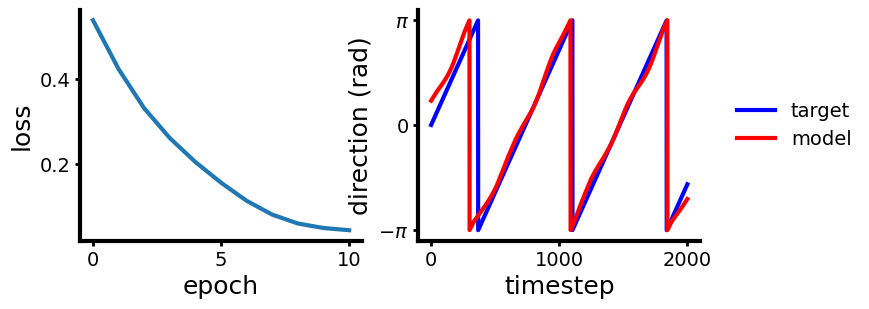

In [389]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
targets_to_plot = targets[0, :, :]
x = torch.Tensor(inputs[0, :, :]).unsqueeze(1)

# forward pass
outputs, _ = net(x)
output_arr = outputs.detach().cpu().numpy()

ax[0].plot(losses)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss') # set y label

ax[1].plot(range(targets.shape[1]), np.arctan2(targets[0, :, 1], targets[0, :, 0]), label='target', color='blue')
ax[1].plot(range(targets.shape[1]), np.arctan2(output_arr.squeeze(1)[:, 1], output_arr.squeeze(1)[:, 0]), label='model', color='red')
ax[1].set_xlabel('timestep') # set x label
ax[1].set_ylabel('direction (rad)') # set y label
ax[1].set_yticks(np.linspace(-np.pi, np.pi, 3), [r'$-\pi$', r'$0$', r'$\pi$'])
ax[1].legend(loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
from IPython.display import clear_output

# Define your plot function
def update(i):
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))  # Optional: Set a figure size
    plt.plot(hidden_activity[0, i, :].T.detach().cpu().numpy(), 'b-', marker='o')
    plt.xlim(0, len(hidden_activity[0, 0, :]))  # Set the x-limits (optional)
    plt.xlabel('Time')
    plt.title(f'Hidden activity at time {i}')

    # show the plot again after updating
    plt.show()

widget = interactive(update, i=(0, 1999, 10))
display(widget)


interactive(children=(IntSlider(value=990, description='i', max=1999, step=10), Output()), _dom_classes=('widg…